In [1]:
import torch
import numpy as np
import os
VERSION = 11
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.insert(0, str(Path(os.path.abspath('')).parent))
from utils.train_util import render
from data.camera import Camera
from utils.compare_quad import setup_camera
from utils import safe_math
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

def compute_delaunay(points):
    """Compute Delaunay tetrahedralization of points."""
    points_cpu = points.cpu().numpy()
    delaunay = Delaunay(points_cpu)
    indices = torch.tensor(delaunay.simplices, device=points.device).int()
    return indices

def generate_color_palette(n_colors):
    """Generate distinct colors using matplotlib colormaps."""
    colors = plt.cm.rainbow(np.linspace(0, 1, n_colors))
    colors = torch.tensor(colors, device='cuda')
    colors[:, 3] = 0.2  # Set alpha value
    return colors.float()

torch.set_printoptions(precision=10)


height, width = 1, 1
fov = 90
g_vertices = torch.tensor([[ 0.2430675477, -0.3873929977,  0.3781652451],
        [ 0.2899414003, -0.1144087315,  0.2279857695],
        [-0.3941484988,  0.2187604010,  0.3265861571],
        [-0.3360970914,  0.1398774236,  0.1634573936]], device='cuda:0')
viewmat = torch.tensor([[-0.7677200437,  0.1756590605,  0.6162384152, -0.0968539640],
        [ 0.3055213988,  0.9456868172,  0.1110551804,  0.0558680296],
        [-0.5632607341,  0.2735333145, -0.7796902657,  0.2879556417],
        [ 0.0000000000,  0.0000000000,  0.0000000000,  1.0000000000]],
       device='cuda:0')
g_vertices = torch.tensor([[-48.7459831238,  49.0388412476,  11.6336460114],
        [-93.3950576782,   0.9913325310,  15.1278495789],
        [ 32.2530975342, -33.7204437256,  53.1733512878],
        [-70.8967895508, -31.2722797394, -34.3268623352],
        [ 33.2293739319,  78.7968292236,   9.0532188416],
        [  4.0731072426, -75.6198730469, -22.6994819641],
        [-73.9028701782,   1.1026263237,  -4.9048004150],
        [ 17.2808170319, -16.4057674408,  45.0614089966],
        [ 67.0716400146, -53.3739433289,  -5.3932371140],
        [-31.4031429291, -20.7615547180,  55.5021171570],
        [ 32.5810203552,  51.8176193237, -39.5931129456],
        [-64.8469543457, -41.1241722107, -35.2347373962],
        [-47.8792724609,  69.5892562866,   6.0590744019]], device='cuda:0')
viewmat = torch.tensor([[-2.1824234724e-01, -7.1014082432e-01,  6.6938054562e-01,
         -1.2062539101e+01],
        [-8.9712494612e-01, -1.2397897989e-01, -4.2402368784e-01,
         -6.8243156433e+01],
        [ 3.8410559297e-01, -6.9305789471e-01, -6.1002749205e-01,
          2.6158626556e+01],
        [ 8.9166862782e-10,  2.1059652633e-10,  2.7297708538e-10,
          1.0000000000e+00]], device='cuda:0')
vertices = torch.tensor([[ 2.0462048054,  6.0099563599, -2.7709932327],
        [ 9.2570934296, -3.4037013054, -0.6154882908],
        [-0.3192037344, -0.4060620070, -4.8382291794],
        [ 2.3484408855, -0.4595559835,  5.1750946045],
        [ 2.0315635204, -8.9080104828,  1.1725664139],
        [-5.5116777420, -4.8009209633, -4.7378311157],
        [-9.1555585861, -1.2241894007, -1.7154008150],
        [ 2.5718522072, -2.6496136189,  0.6982851028],
        [-0.3329432011, -1.1659097672, -2.4887781143],
        [ 1.0286951065, -5.4186248779, -1.0571700335]], device='cuda:0')
viewmat = torch.tensor([[-6.2930476665e-01, -5.1553761959e-01,  5.8154672384e-01,
          6.3674771786e-01],
        [ 8.2019373775e-02, -7.8817689419e-01, -6.0995894670e-01,
         -2.4096879959e+00],
        [ 7.7281844616e-01, -3.3615204692e-01,  5.3828763962e-01,
          1.2050601244e+00],
        [ 1.4261853920e-09, -2.2020444135e-08,  1.1744639039e-08,
          1.0000000000e+00]], device='cuda:0')

if g_vertices.shape[0] == 4:
    indices = torch.tensor([[0, 1, 2, 3]]).int().cuda()
else:
    indices = compute_delaunay(g_vertices)
colors = generate_color_palette(len(indices))[:, :3]

tet_density = 0.1*torch.rand((len(indices),), device='cuda')

# Setup camera
viewmat, projection_matrix, cam_pos, fovy, fovx, fx, fy = setup_camera(height, width, fov, viewmat)
# Now extract R,T from viewmat
# If viewmat is truly "World->View", then R is top-left 3x3, T is top-right 3x1
# V = torch.inverse(viewmat)
V = viewmat
R = V[:3, :3].T
T = V[:3, 3]

# Create a blank image for the camera
blank_image = torch.zeros((3, height, width), device="cuda")

# Instantiate the camera
camera = Camera(
    colmap_id = 0,
    R = R.cpu().numpy(),
    T = T.cpu().numpy(),
    fovx = fovx,
    fovy = fovy,
    image = blank_image,
    gt_alpha_mask = None,
    uid = 0,
    cx = -1,
    cy = -1,
    trans = np.array([0.0, 0.0, 0.0]), # or any translation offset you need
    scale = 1.0,
    data_device = "cuda",
    # You can add any extra distortions, exposure, etc. you might need
)
def f(v, t):
    model = lambda x: x
    model.vertices = v

    model.vertex_color = colors.clone().cuda()
    model.tet_density = t
    model.indices = indices
    model.scene_scaling = 1
    def get_cell_values(camera, mask=None):
        if mask is not None:
            return model.vertex_color, tet_density[mask]
        else:
            return model.vertex_color, tet_density
    model.get_cell_values = get_cell_values

    render_pkg = render(camera, model, tile_size=16, min_t=0, ladder_p=1, pre_multi=1)
    torch_loss = render_pkg['distortion_loss'].mean()
    # torch_loss = render_pkg['render'].mean()
    return torch_loss


# Detach and enable gradients
def f_density(t):
    model = lambda x: x
    vertices = g_vertices.clone()
    model.vertices = vertices

    model.vertex_color = colors.clone().cuda()
    model.tet_density = t
    model.indices = indices
    model.scene_scaling = 1
    def get_cell_values(camera, mask=None):
        if mask is not None:
            return model.vertex_color, tet_density[mask]
        else:
            return model.vertex_color, tet_density
    model.get_cell_values = get_cell_values

    render_pkg = render(camera, model, tile_size=16, min_t=0, ladder_p=1, pre_multi=1)
    torch_loss = render_pkg['distortion_loss'].mean()
    print('alpha', render_pkg['render'].reshape(-1), 1-render_pkg['alpha'])
    # torch_loss = render_pkg['render'].mean()
    return torch_loss

vertices = g_vertices.requires_grad_(True)
tet_density = tet_density.requires_grad_(True)
slang_dist_loss = f_density(tet_density)
print('dist', slang_dist_loss)
slang_dist_loss.backward()
print('grad', tet_density.grad, vertices.grad)

# torch.autograd.gradcheck(f_density, (tet_density))
# torch.autograd.gradcheck(f, (g_vertices, tet_density))

/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for co

0.000000 - 24.810738, d: 0.014088, v: 0.000000 T: 1.000000
0.000000 - 0.000000, d: 0.036416, v: 0.000000 T: 0.705016
0.000000 - 0.000000, d: 0.022896, v: 0.000000 T: 0.705016
0.000000 - 0.000000, d: 0.019318, v: 0.000000 T: 0.705016
24.810738 - 41.573494, d: 0.095815, v: 0.000000 T: 0.705016
0.000000 - 0.000000, d: 0.052299, v: 0.000000 T: 0.141472
0.000000 - 0.000000, d: 0.001027, v: 0.000000 T: 0.141472
0.000000 - 0.000000, d: 0.024956, v: 0.000000 T: 0.141472
0.000000 - 0.000000, d: 0.065670, v: 0.000000 T: 0.141472
0.000000 - 0.000000, d: 0.022698, v: 0.000000 T: 0.141472
41.573494 - 47.601089, d: 0.053464, v: 0.000000 T: 0.141472
0.000000 - 0.000000, d: 0.047415, v: 0.000000 T: 0.102498
47.601089 - 56.057827, d: 0.023390, v: 0.000000 T: 0.102498
0.000000 - 0.000000, d: 0.096581, v: 0.000000 T: 0.084103
0.000000 - 0.000000, d: 0.051465, v: 0.000000 T: 0.084103
alpha tensor([0.1141709536, 0.7190202475, 0.8141859174], device='cuda:0',
       grad_fn=<ViewBackward0>) tensor([[0.915897

[[[ 0.11414314  0.71885437  0.8139961   0.9156836  10.998466  ]]]


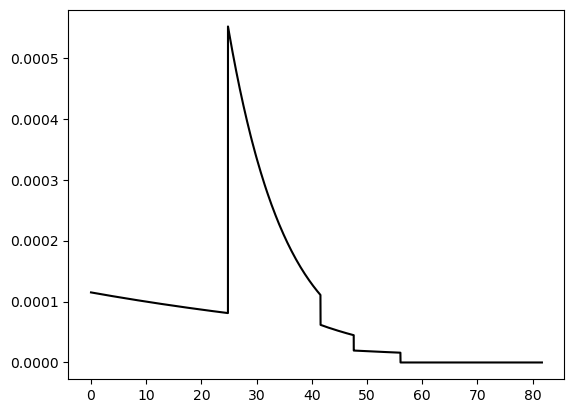

In [2]:
from jaxutil import tetra_quad
import matplotlib.pyplot as plt

vertex_color = colors.clone().cuda()

n_samples = 10000
tmin = 0

jax_image, extras = tetra_quad.render_camera(
    g_vertices.detach().cpu().numpy(), indices.cpu().numpy(),
    vertex_color.detach().cpu().numpy(),
    tet_density.detach().cpu().numpy(),
    height, width, viewmat.cpu().numpy(),
    fx.item(), fy.item(), tmin, np.linspace(0, 1, n_samples))
print(jax_image)
tdist = extras['tdist'][0, 0]
weights = extras['weights'][0, 0, 0]
plt.plot(tdist[:-1], weights, c='black')
plt.show()

[ 0.       24.812796 41.56981  47.599392 56.05551 ] [0.01408802 0.09581484 0.05346429 0.02338976] [[[[0.01408802 0.01408802 0.01408802 ... 0.         0.
    0.        ]]]]


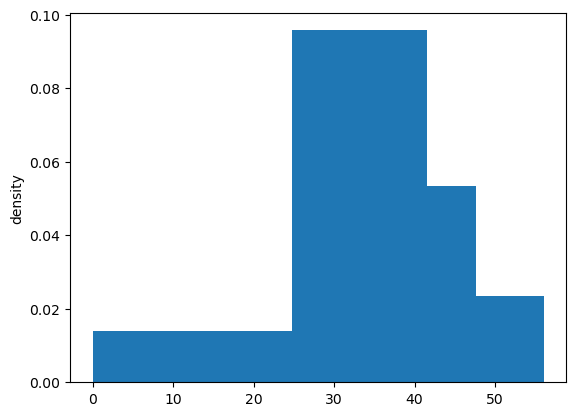

In [3]:
def bar_plot(ft_np, fv):
    mid_points = 0.5 * (ft_np[:-1] + ft_np[1:])
    widths = ft_np[1:] - ft_np[:-1]

    plt.bar(mid_points, fv, width=widths)#, edgecolor="black")
    plt.ylabel('density')
    
def compress_piecewise_constant(t, v):
    ft = [t[0]]
    fv = [v[0]]
    for i in range(1, len(t)):
        if v[i] != v[i - 1]:
            ft.append(t[i])
            fv.append(v[i])

    return np.array(ft), np.array(fv)
density_samples = extras['total_density']
ft, fv = compress_piecewise_constant(tdist.reshape(-1), density_samples.reshape(-1))
fv = fv[:-1]
print(ft, fv, density_samples)
bar_plot(ft, fv)
plt.show()

In [4]:
import jax.numpy as jnp
from jax import grad

def jf(verts_and_rgbs):
    verts, vertex_colors, tet_density = verts_and_rgbs
    img, _ = tetra_quad.render_camera(
        verts,
        indices.cpu().numpy(),
        vertex_colors,
        tet_density,
        height, width, viewmat.cpu().numpy(),
        fx.item(), fy.item(),
        tmin,
        jnp.linspace(0, 1, n_samples)
    )
    dist = img[..., 4]
    return dist.mean()
    return img[..., :3].mean()

# Compute JAX gradients using jacrev
jax_verts_grad, jax_vertex_color_grad, jax_tet_density_grad = grad(jf)((
    vertices.detach().cpu().numpy(),
    vertex_color.detach().cpu().numpy(),
    tet_density.detach().cpu().numpy()
))

print(jax_tet_density_grad)

[  0.         -0.4884898   0.          0.          0.          0.
  16.051657   33.61937     0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        233.98721     0.          0.          0.          0.
   0.          0.       ]


In [5]:
def moment_0_int_torch(a, b, s):
    # a, b, s are torch Tensors
    return (1.0 - torch.exp(s * (a - b))) / s

def moment_1_int_torch(a, b, s):
    # If s is extremely small, return the series-limit value: (b^2 - a^2) / 2
    # because the expression has a well-defined limit as s -> 0.
    if torch.abs(s) < 1e-5:
        return 0.5 * (b**2 - a**2)
    else:
        # Direct computation. If you want to be safer against cancellation
        # at moderate s, you can rewrite:
        # (a*s + 1 - (b*s + 1) * exp(ds)) / s^2
        # with ds = s*(a-b).
        
        ds = s*(a - b)
        numer = a*s - (b*s + 1.0)*torch.exp(ds) + 1.0
        denom = s**2
        return numer / denom
    # return (a*s - (b*s + 1.0)*torch.exp(s*(a - b)) + 1.0) / (s**2)

# def self_dist_torch(a, b, s):
#     ds = s*(a - b)
#     numer = (2.0*ds*torch.exp(ds) - torch.expm1(2.0*ds))
#     denom = (s**3)
#     return numer / denom
def self_dist_torch(a, b, s):
    # a, b, s can be scalars or tensors (of matching shapes)
    ds = s * (a - b)
    print(ds)
    if (ds > -1e-4):
        return -1/3 * (a-b)**3
    else:
        denom = (s**3)
        numer = (2.0*ds*torch.exp(ds) / denom + 1.0 / denom - torch.exp(2.0*ds) / denom)
        return numer
    log_s = 3.0 * torch.log(s)
    # 2*ds * exp(ds - log_s) + 1/(s^3) - exp(2*ds - log_s)
    # return -1/3 * (a-b)**3
    return 2.0 * ds * torch.exp(ds - log_s) + 1.0 / (s*s*s) - torch.exp(2.0 * ds - log_s)

# def self_dist_torch(a, b, s):
#     ds = s*(a - b)
#     return numer
def update_distortion_state_torch(state, t1, t2, sigma):
    """
    state is [x, y, z, w, v, T]
    t1, t2, sigma are scalars (torch tensors)
    """
    x, y, z, w, v, T = state

    m0 = T * moment_0_int_torch(t1, t2, sigma)
    m1 = T * moment_1_int_torch(t1, t2, sigma)

    new_z = z + m0
    new_w = w + m1
    new_x = x + z*m1
    new_y = y + w*m0

    # self_dist doesn't get multiplied by state-dependent terms (except T^2),
    # so that is direct from the integral:
    new_v = v + T*T* self_dist_torch(t1, t2, sigma)

    alpha = 1.0 - torch.exp(-sigma * (t2 - t1))
    new_T = T * (1.0 - alpha)

    return torch.stack([new_x, new_y, new_z, new_w, new_v, new_T])

def incremental_distortion_torch(t, sigma):
    """
    t: sorted boundaries, shape [N+1]
    sigma: densities, shape [N]
    """
    # state = [x, y, z, w, v, T], initialize as zeros but T=1
    state = torch.zeros(6, dtype=torch.float32, device=t.device)
    state[-1] = 1.0  # T=1
    for i in range(len(sigma)):
        state = update_distortion_state_torch(
            state,
            t[i], t[i+1],
            sigma[i]
        )
    x, y, _, _, v, _ = state
    # print(x, y, v)
    return 2.0*(x - y) + v

ft_t = torch.as_tensor(ft)
ft_t.requires_grad = True
fv_t = torch.as_tensor(fv)
fv_t.requires_grad = True
print(ft_t)
print(fv_t)
dist_loss = incremental_distortion_torch(ft_t, fv_t)
print('torch_dist', dist_loss)
dist_loss.backward()
print('torch_grad', fv_t.grad)

tensor([ 0.0000000000, 24.8127956390, 41.5698089600, 47.5993919373,
        56.0555114746], requires_grad=True)
tensor([0.0140880151, 0.0958148390, 0.0534642935, 0.0233897623],
       requires_grad=True)
tensor(-0.3495630324, grad_fn=<MulBackward0>)
tensor(-1.6055705547, grad_fn=<MulBackward0>)
tensor(-0.3223673999, grad_fn=<MulBackward0>)
tensor(-0.1977866292, grad_fn=<MulBackward0>)
torch_dist tensor(11192.0400390625, grad_fn=<AddBackward0>)
torch_grad tensor([-353839.5000000000,  -83163.6640625000,  -12496.4951171875,
          -6476.7988281250])


In [6]:
inds = torch.as_tensor([torch.where(tet_density==v)[0][0] for v in fv_t])
print('our grad', tet_density.grad[inds])
print(slang_dist_loss)


our grad tensor([-258338.9375000000,  -80570.3828125000,  -12459.8613281250,
          -6460.6430664062], device='cuda:0')
tensor(7398.5541992188, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
# 0.000000 - 24.810738, d: 0.014088, v: 0.000000 T: 1.000000
# 24.810738 - 41.573494, d: 0.095815, v: 0.000000 T: 0.705016
# 41.573494 - 47.601089, d: 0.053464, v: 0.000000 T: 0.141472
# 47.601089 - 56.057827, d: 0.023390, v: 0.000000 T: 0.102498

In [7]:
ft_t = torch.as_tensor(ft)
ft_t.requires_grad = True
fv_t = torch.as_tensor(fv[:1])
fv_t.requires_grad = True
sdt = self_dist_torch(ft_t[0], ft_t[1], fv_t[0])
print(sdt)
sdt.backward()
print(fv_t.grad)

tensor(-0.3495630324, grad_fn=<MulBackward0>)
tensor(3611.9687500000, grad_fn=<SubBackward0>)
tensor([-86482.2500000000])
